In [1]:
# установим нужную библиотеку
#!pip install tinvest[cli]

# 1. Получение токена и проверка соединения с сервером

Ссылка на github, откуда берется библиотека: https://github.com/daxartio/tinvest

Ссылка на документацию по использованию API Tinkoff: https://tinkoffcreditsystems.github.io/invest-openapi/

Устанавливаем необходимую библиотеку. Далее нужно получить токен. Как это сделать - описано здесь: https://tinkoffcreditsystems.github.io/invest-openapi/auth/

Запишем токен в отдельном файле `tinkoff_token` в переменную `token` и импортируем

In [2]:
import tinvest
import pandas as pd
import numpy as np
from decimal import Decimal
from tinkoff_token import token # токен хранится здесь
import plotly.express as px

In [3]:
TOKEN = token
client = tinvest.SyncClient(TOKEN)

response = client.get_portfolio()  # tinvest.PortfolioResponse
#print(response.payload)

Напишем примитивную функцию проверки обработки нашего запроса

In [4]:
def check_response_status(response):
    if response.status == 'Ok':
        return 'Запрос обработан'
    return 'Ошибка обработки запроса'

In [5]:
check_response_status(response)

'Запрос обработан'

Токен работает, сервер отвечает.

Теперь получим `id` брокерского аккаунта. У меня их два: ИИС и обычный. Всё самое интересное лежит на обычном аккаунте, поэтому возьмем его и по этому `id` обновим ответ сервера

In [6]:
broker_account_id='2038650350'
response = client.get_portfolio(broker_account_id='2038650350')

In [7]:
#response

Видим, что в `response` лежит не человекочитаемый формат. Распарсим его, приведя в итоге к классическому `pandas.DataFrame`

In [8]:
all_positions = response.payload.positions

# 2. Получение, преобразование и анализ данных по портфелю

Для этого напишем простую функцию под каждый интересующий нас параметр, вызовем и результат работы поместим в DataFrame.

Список интересующих нас параметров:

<li> Position - наименование финансового инструмента 
<li> Instrument_type - тип финансового инструмента (stock, bond, etf, currency)
<li> Balance - количество бумаг в портфеле
<li> Avg_position_price - усредненная цена покупки
<li> Total_price - цена актива. Рассчитывается как balance * avg_position_price
<li> Profit - величина дохода в случае продажи в абсолютных единицах (может быть и отрицательной)
<li> Profit_percent - величина дохода в случае продажи в процентах (может быть и отрицательной)
<li> Currency - валюта
<li> Ticker - тикер финансового инструмента

P.S. Profit обновляется каждый раз при новом запросе к серверу

In [9]:
def get_all_position_names(all_positions):
    names = []
    for position in all_positions:
        names.append(position.name)
    return names

In [10]:
def get_instrument_type(all_positions):
    instrument_type = []
    for position in all_positions:
        instrument_type.append(position.instrument_type.replace('InstrumentType', ''))
    return instrument_type

In [11]:
def get_balance(all_positions):
    balance = []
    for position in all_positions:
        balance.append(position.balance)
    return balance

In [12]:
def get_avg_position_price(all_positions):
    avg_position_price = []
    for position in all_positions:
        avg_position_price.append(position.average_position_price.value.quantize(Decimal('1.00')))
    return avg_position_price

In [13]:
def get_figi(all_positions):
    figis = []
    for i, figi in enumerate(all_positions):
        figis.append(all_positions[i].figi)
    return figis


def get_current_price_by_figi(client, figis):
    current_price = []
    for figi in figis:
        try:
            current_price.append((client.get_market_orderbook(figi=figi, depth=1)).payload.asks[0].price)
        except:
            current_price.append((client.get_market_orderbook(figi=figi, depth=1)).payload.close_price)
    return current_price

In [14]:
def get_total_price(balance, current_position_price):
    total_price = []
    for i, elem in enumerate(balance):
        total_price.append((balance[i] * current_position_price[i].quantize(Decimal('1.00'))))
    return total_price

In [15]:
def get_expected_profit(all_positions):
    profit = []
    for positions in all_positions:
        profit.append(positions.expected_yield.value)
    return profit

In [16]:
def get_expected_profit_percent(balance, avg_position_price, profit):
    profit_percent = []
    for i, elem in enumerate(profit):
        profit_percent.append(f'{((profit[i] / (balance[i] * avg_position_price[i])) * 100).quantize(Decimal("1.00"))}%')
    return profit_percent

In [17]:
def get_currency(all_positions):
    currency = []
    for position in all_positions:
        currency.append(position.average_position_price.currency.replace('Currency.', ''))
    return currency

In [18]:
def get_ticker(all_positions):
    tickers = []
    for position in all_positions:
        tickers.append(position.ticker)
    return tickers

Мы написали все необходимые для начала функции. Следующим шагом их нужно вызвать. Запишем результат работы каждой функции в соответсвующую переменную и затем передадим в датафрейм

In [19]:
name = get_all_position_names(all_positions)
instrument_type = get_instrument_type(all_positions)
balance = get_balance(all_positions)
avg_position_price = get_avg_position_price(all_positions)
currency = get_currency(all_positions)
tickers = get_ticker(all_positions)
profit = get_expected_profit(all_positions)
figis = get_figi(all_positions)
current_position_price = get_current_price_by_figi(client, figis)
total_price = get_total_price(balance, current_position_price)
profit_percent = get_expected_profit_percent(balance, avg_position_price, profit)

In [20]:
portfolio = pd.DataFrame({'position': name, 'instrument_type': instrument_type,
                    'balance': balance, 'avg_position_price': avg_position_price,
                    'current_position_price': current_position_price,
                    'total_price': total_price, 'profit': profit, 
                     'profit_percent': profit_percent,
                     'currency': currency, 'ticker': tickers
                    })

In [21]:
portfolio

,position,instrument_type,balance,avg_position_price,current_position_price,total_price,profit,profit_percent,currency,ticker
0,Полюс Золото,Stock,1,17156.00,13702,13702.00,-3453.5,-20.13%,RUB,PLZL
1,Polymetal,Stock,3,1962.40,1550.5,4651.50,-1235.7,-20.99%,RUB,POLY
2,ГДР X5 RetailGroup,Stock,3,2808.50,2332,6996.00,-1429.5,-16.97%,RUB,FIVE
3,United medical group,Stock,24,928.19,916.01,21984.24,-292.26,-1.31%,RUB,GEMC
4,Аэрофлот,Stock,20.0,73.90,67.08,1341.600,-136.4,-9.23%,RUB,AFLT
5,Alibaba,Stock,1,263.30,207.29,207.29,-55.91,-21.23%,USD,BABA
6,Уралкалий выпуск 6,Bond,6,1034.40,953.9,5723.40,-321,-5.17%,RUB,RU000A101GZ6
7,Тинькофф Банк выпуск 3,Bond,5,1056.03,1006,5030.00,-110.0,-2.08%,RUB,RU000A100V79
8,О'КЕЙ выпуск 3,Bond,5,1021.73,983.7,4918.50,-130.5,-2.55%,RUB,RU000A1014B9
9,Гарант-Инвест БО 001P-05,Bond,1,766.22,790.395,790.40,29.55,3.86%,RUB,RU000A1005T9


Данные получены и преобразованы в более понятный для человека формат, однако не хватает множества вспомогательных величин. Например:
<li> Общий объём портфеля (в рублях и долларах)
<li> Профит портфеоя в абсолютных единицах (в рублях и долларах)
<li> Остаток валюты (в рубли и долларах) </li>
    


### Объем портфеля и остаток валюты

In [22]:
def get_portfolio_currency():
    currencies = client.get_portfolio_currencies() # получаем список валют: eur, rub, usd
    rub = currencies.payload.currencies[1].balance # выбираем rub
    usd = currencies.payload.currencies[2].balance # выбираем usd
    return rub, usd

In [23]:
def get_course_usd_to_rub():
    dollar_figi = 'BBG0013HGFT4'
    try: # если торги активны
        return (client.get_market_orderbook(figi=dollar_figi, depth=1)).payload.asks[0].price # получаем текущий курс доллара
    except: # если торги неактивны
        return client.get_market_orderbook(figi=dollar_figi, depth=1).payload.close_price

In [24]:
def get_total_rub_position(portfolio):
    return portfolio.loc[portfolio['currency'] == 'RUB']['total_price'].sum()

In [25]:
def get_total_usd_position(portfolio):
    return portfolio.loc[portfolio['currency'] == 'USD']['total_price'].sum()

In [26]:
def get_total_portfolio_rub(portfolio):
    rub, usd = get_portfolio_currency() # получаем остаток рублей и долларов в портфеле
    course_usd_to_rub = get_course_usd_to_rub() # получаем актуальный курс доллара
    rub_position = get_total_rub_position(portfolio) # складываем все рублевые активы
    usd_position = get_total_usd_position(portfolio) # складываем все долларовые активы
    total_sum_rub = rub + rub_position + course_usd_to_rub * (usd + usd_position) # суммируем все и переводим доллары в рубли
    return f'Объём портфеля в рублях: {total_sum_rub.quantize(Decimal("1.00"))}р', total_sum_rub

In [27]:
def get_total_portfolio_usd(portfolio):
    rub, usd = get_portfolio_currency() # получаем остаток рублей и долларов в портфеле
    course_usd_to_rub = get_course_usd_to_rub() # получаем актуальный курс доллара
    rub_position = portfolio.loc[portfolio['currency'] == 'RUB']['total_price'].sum() # складываем все рублевые активы
    usd_position = portfolio.loc[portfolio['currency'] == 'USD']['total_price'].sum() # складываем все долларовые активы
    total_sum_usd = (rub + rub_position) / course_usd_to_rub + usd + usd_position # суммируем все и переводим доллары в рубли
    return f'Объём портфеля в долларах: {total_sum_usd.quantize(Decimal("1.00"))}$', total_sum_usd

In [28]:
total_portfolio_rub, total_sum_rub = get_total_portfolio_rub(portfolio)
total_portfolio_rub

'Объём портфеля в рублях: 96202.21р'

In [29]:
total_portfolio_usd, total_sum_usd = get_total_portfolio_usd(portfolio)
total_portfolio_usd

'Объём портфеля в долларах: 1306.61$'

### Профит портфеля

In [30]:
def get_rub_profit_position(portfolio):
    return portfolio.loc[portfolio['currency'] == 'RUB']['profit'].sum()

In [31]:
def get_usd_profit_position(portfolio):
    return portfolio.loc[portfolio['currency'] == 'USD']['profit'].sum()

In [32]:
def get_total_profit_rub(portfolio):
    course_usd_to_rub = get_course_usd_to_rub() # получаем актуальный курс доллара
    rub_position = get_rub_profit_position(portfolio) # складываем все рублевые активы
    usd_position = get_usd_profit_position(portfolio) # складываем все долларовые активы
    total_profit = rub_position + course_usd_to_rub * usd_position # суммируем все и переводим доллары в рубли
    return f'Профит портфеля в рублях: {total_profit.quantize(Decimal("1.00"))}р', \
           f'Профит портфеля в процентах: {((total_profit / total_sum_rub)*100).quantize(Decimal("1.00"))}%', \
           total_profit

In [33]:
get_total_profit_rub(portfolio)

('Профит портфеля в рублях: -10041.81р',
 'Профит портфеля в процентах: -10.44%',
 Decimal('-10041.814150'))

In [34]:
def get_total_profit_usd(portfolio):
    course_usd_to_rub = get_course_usd_to_rub() # получаем актуальный курс доллара
    rub_position = get_rub_profit_position(portfolio) # складываем все рублевые активы
    usd_position = get_usd_profit_position(portfolio) # складываем все долларовые активы
    total_profit = rub_position / course_usd_to_rub + usd_position # суммируем все и переводим доллары в рубли
    return f'Профит портфеля в долларах: {total_profit.quantize(Decimal("1.00"))}$', \
           f'Профит портфеля в процентах: {((total_profit / total_sum_usd) * 100).quantize(Decimal("1.00"))}%', \
           total_profit

In [35]:
get_total_profit_usd(portfolio)

('Профит портфеля в долларах: -136.39$',
 'Профит портфеля в процентах: -10.44%',
 Decimal('-136.3867325387932498047604496'))

### Профит портфеля с учетом ндфл 13%

In [36]:
def get_total_profit_rub_after_taxes(portfolio):
    tax_size = 0.87 # возьмем сразу величину 0.87 для дальнейших расчетов
    total_sum = get_total_profit_rub(portfolio)
    if total_sum[2] > 0:
        return 'После уплаты НДФЛ 13%:',total_sum[1], (total_sum[2] * tax_size).quantize(Decimal("1.00"))
    return 'После уплаты НДФЛ 13%:', total_sum[1], total_sum[2].quantize(Decimal("1.00"))

In [37]:
get_total_profit_rub_after_taxes(portfolio)

('После уплаты НДФЛ 13%:',
 'Профит портфеля в процентах: -10.44%',
 Decimal('-10041.81'))

In [38]:
def get_total_profit_usd_after_taxes(portfolio):
    tax_size = 0.87 # возьмем сразу величину 0.87 для дальнейших расчетов
    total_sum = get_total_profit_usd(portfolio)
    if total_sum[2] > 0:
        return 'После уплаты НДФЛ 13%:',total_sum[1], (total_sum[2] * tax_size).quantize(Decimal("1.00"))
    return 'После уплаты НДФЛ 13%:', total_sum[1], total_sum[2].quantize(Decimal("1.00"))

In [39]:
get_total_profit_usd_after_taxes(portfolio)

('После уплаты НДФЛ 13%:',
 'Профит портфеля в процентах: -10.44%',
 Decimal('-136.39'))

### Аналитика портфеля

Взглянем на соотношение рублевых и долларовых инструментов в портфеле. Для этого надо немного обработать данные, в частности перевести все долларовые цены в рублевые (можно и наоборот), чтобы смотреть доли в одной системе счисления

In [40]:
usd_course = get_course_usd_to_rub() # получаем курс доллара
currency_part = portfolio[['total_price', 'currency']] # делаем срез по двум интересующим нас столбцам

usd_currency_part = currency_part.loc[currency_part['currency'] == 'USD'] # выделяем рублевые
rub_currency_part = currency_part.loc[currency_part['currency'] == 'RUB']

usd_currency_part['total_price_rub'] = (usd_currency_part['total_price'] * usd_course)
rub_currency_part['total_price_rub'] =rub_currency_part['total_price']
currency_part = usd_currency_part.merge(right=rub_currency_part, how='outer')

<ipython-input-40-47228ad04780>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_currency_part['total_price_rub'] = (usd_currency_part['total_price'] * usd_course)
<ipython-input-40-47228ad04780>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rub_currency_part['total_price_rub'] =rub_currency_part['total_price']


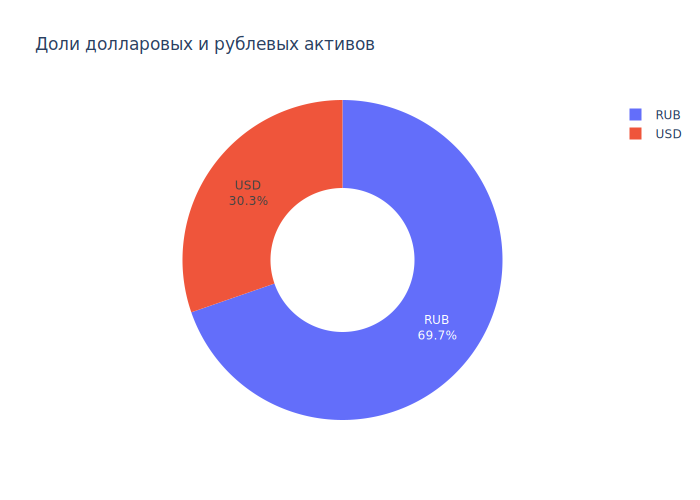

In [41]:
fig = px.pie(currency_part, values='total_price_rub', names='currency', title='Доли долларовых и рублевых активов', hole=0.45)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show(renderer="svg")

In [42]:
# TODO
# 1. Operation list